In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [3]:
df_train = pd.read_csv("train.csv")
df_val = pd.read_csv("val.csv")
df_test = pd.read_csv("test.csv")

features_cols = ['gunning_fog', 'smog_index', 'subjectivity', 'title_text_similarity', 'words_per_sentence',
    'adv_ratio_title', 'noun_ratio_title', 'words_per_title', 'syllables_per_word',
    'uppercase_per_title', 'uppercase_ratio_title_text', 'adj_ratio_text', 'adv_ratio_text',
    'verb_ratio_text', 'noun_ratio_text', 'short_sentences_ratio', 'long_sentences_ratio']

y_train = df_train['label'].values
y_val = df_val['label'].values
y_test = df_test['label'].values

X_train = df_train[features_cols].values
X_val = df_val[features_cols].values
X_test = df_test[features_cols].values

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [5]:
def load_embedding_and_mask(idx, folder_path):
    embedding = np.load(f"{folder_path}/embedding_{idx}.npy")
    mask = np.load(f"{folder_path}/mask_{idx}.npy")
    return torch.tensor(embedding, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

In [6]:
def create_batch_with_features(indices, folder_path, labels, features):
    embeddings, masks, feats, lbls = [], [], [], []
    for idx in indices:
        emb, mask = load_embedding_and_mask(idx, folder_path)
        embeddings.append(emb)
        masks.append(mask)
        feats.append(features[idx])
        lbls.append(labels[idx])

    embeddings = torch.stack(embeddings).to(device)
    masks = torch.stack(masks).to(device)
    feats = torch.tensor(np.array(feats), dtype=torch.float32).to(device)
    lbls = torch.tensor(lbls).to(device)
    return embeddings, masks, feats, lbls

In [7]:
def evaluate_model(lstm, linear, folder_path, labels, features, batch_size=64):
    lstm.eval()
    linear.eval()
    preds, labs = [], []
    with torch.no_grad():
        for i in range(0, len(labels), batch_size):
            idx = list(range(i, min(i+batch_size, len(labels))))
            emb, mask, feats, lbls = create_batch_with_features(idx, folder_path, labels, features)
            out, _ = lstm(emb)
            lens = mask.sum(1) - 1
            last = out[torch.arange(out.size(0)), lens.long()]
            concat = torch.cat((last, feats), dim=1)
            logit = linear(concat)
            preds.append(torch.argmax(logit, dim=1).cpu())
            labs.append(lbls.cpu())
    p = torch.cat(preds)
    l = torch.cat(labs)
    return p, l, (p == l).float().mean().item()

In [8]:
embedding_dim = 768
hidden_dim = 256
num_extra_features = X_train.shape[1]

lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
linear = nn.Sequential(
    nn.Linear(hidden_dim * 2 + num_extra_features, hidden_dim),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(hidden_dim, 2))
lstm, linear = lstm.to(device), linear.to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(lstm.parameters()) + list(linear.parameters()), lr=1e-4)

num_epochs = 5
batch_size = 32
folders = {"train": "train_bert_embeddings", "val": "val_bert_embeddings", "test": "test_bert_embeddings"}
history = {'train_loss': [], 'train_acc': [], 'val_acc': [], 'test_acc': []}

for epoch in range(num_epochs):
    lstm.train()
    linear.train()
    total_loss = 0
    all_preds, all_labels = [], []
    indices = list(range(len(y_train)))
    np.random.shuffle(indices)

    for i in tqdm(range(0, len(indices), batch_size), desc=f"Epoch {epoch+1}/{num_epochs}"):
        idx = indices[i:i+batch_size]
        emb, mask, feats, labs = create_batch_with_features(idx, folders["train"], y_train, X_train)

        optimizer.zero_grad()
        out, _ = lstm(emb)
        lens = mask.sum(1) - 1
        last = out[torch.arange(out.size(0)), lens.long()]
        concat = torch.cat((last, feats), dim=1)
        logit = linear(concat)
        loss = criterion(logit, labs)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        all_preds.append(torch.argmax(logit, dim=1).cpu())
        all_labels.append(labs.cpu())

    train_acc = (torch.cat(all_preds) == torch.cat(all_labels)).float().mean().item()
    _, _, val_acc = evaluate_model(lstm, linear, folders["val"], y_val, X_val)
    _, _, test_acc = evaluate_model(lstm, linear, folders["test"], y_test, X_test)

    history['train_loss'].append(total_loss / (len(indices) / batch_size))
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['test_acc'].append(test_acc)

    print(f"Epoch {epoch+1} | Loss: {history['train_loss'][-1]:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}")

Epoch 1/5: 100%|██████████| 1236/1236 [13:30<00:00,  1.52it/s]


Epoch 1 | Loss: 0.2755 | Train Acc: 0.8847 | Val Acc: 0.9291 | Test Acc: 0.9230


Epoch 2/5: 100%|██████████| 1236/1236 [12:40<00:00,  1.63it/s]


Epoch 2 | Loss: 0.1733 | Train Acc: 0.9318 | Val Acc: 0.9285 | Test Acc: 0.9230


Epoch 3/5: 100%|██████████| 1236/1236 [12:32<00:00,  1.64it/s]


Epoch 3 | Loss: 0.1424 | Train Acc: 0.9459 | Val Acc: 0.9441 | Test Acc: 0.9412


Epoch 4/5: 100%|██████████| 1236/1236 [12:30<00:00,  1.65it/s]


Epoch 4 | Loss: 0.1188 | Train Acc: 0.9544 | Val Acc: 0.9484 | Test Acc: 0.9456


Epoch 5/5: 100%|██████████| 1236/1236 [11:34<00:00,  1.78it/s]


Epoch 5 | Loss: 0.0934 | Train Acc: 0.9655 | Val Acc: 0.9472 | Test Acc: 0.9477


In [10]:
pd.DataFrame(history).to_csv("bert_lstm_features_32_history.csv", index=False)

In [11]:
y_pred, y_true, _ = evaluate_model(lstm, linear, folders["test"], y_test, X_test)
print("\nClassification Report:")
print(classification_report(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      6883
           1       0.95      0.93      0.94      5471

    accuracy                           0.95     12354
   macro avg       0.95      0.95      0.95     12354
weighted avg       0.95      0.95      0.95     12354



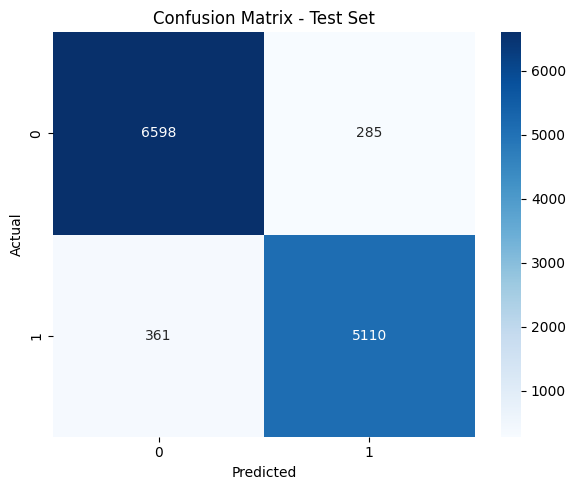

In [12]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')
plt.tight_layout()

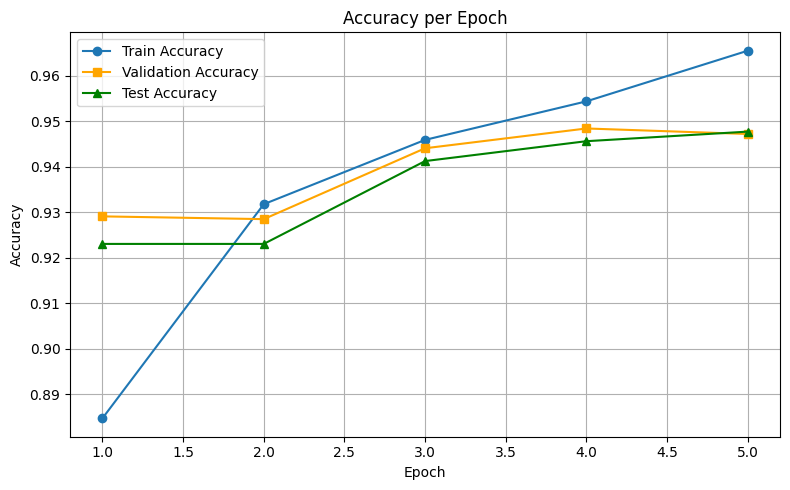

In [13]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs, history['train_acc'], label='Train Accuracy', marker='o')
plt.plot(epochs, history['val_acc'], label='Validation Accuracy', marker='s', color='orange')
plt.plot(epochs, history['test_acc'], label='Test Accuracy', marker='^', color='green')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()

In [14]:
torch.save((lstm, linear), "bert_lstm_features_32_model_extensie.pt")
import joblib
joblib.dump(scaler, "scaler_bert.pkl")

['scaler_bert.pkl']